In [ ]:
import tensorflow as tf
import os

In [ ]:
input_dir = "/content/drive/MyDrive/FESB_MLID/train_images/src"
target_dir = "/content/drive/MyDrive/FESB_MLID/train_images/gt"

img_size = (256, 256)
num_classes = 256
batch_size = 10

In [ ]:
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

In [ ]:
len(input_img_paths)

200

In [ ]:
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".bmp") and not fname.startswith(".")
    ]
)

In [ ]:
len(target_img_paths)

200

In [ ]:
for input_path, target_path in zip(input_img_paths, target_img_paths):
    print(input_path, "|", target_path)

/content/drive/MyDrive/FESB_MLID/train_images/src/src_1.jpg | /content/drive/MyDrive/FESB_MLID/train_images/gt/gt_1.bmp
/content/drive/MyDrive/FESB_MLID/train_images/src/src_100.jpg | /content/drive/MyDrive/FESB_MLID/train_images/gt/gt_100.bmp
/content/drive/MyDrive/FESB_MLID/train_images/src/src_102.jpg | /content/drive/MyDrive/FESB_MLID/train_images/gt/gt_102.bmp
/content/drive/MyDrive/FESB_MLID/train_images/src/src_103.jpg | /content/drive/MyDrive/FESB_MLID/train_images/gt/gt_103.bmp
/content/drive/MyDrive/FESB_MLID/train_images/src/src_104.jpg | /content/drive/MyDrive/FESB_MLID/train_images/gt/gt_104.bmp
/content/drive/MyDrive/FESB_MLID/train_images/src/src_108.jpg | /content/drive/MyDrive/FESB_MLID/train_images/gt/gt_108.bmp
/content/drive/MyDrive/FESB_MLID/train_images/src/src_11.jpg | /content/drive/MyDrive/FESB_MLID/train_images/gt/gt_11.bmp
/content/drive/MyDrive/FESB_MLID/train_images/src/src_114.jpg | /content/drive/MyDrive/FESB_MLID/train_images/gt/gt_114.bmp
/content/drive

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

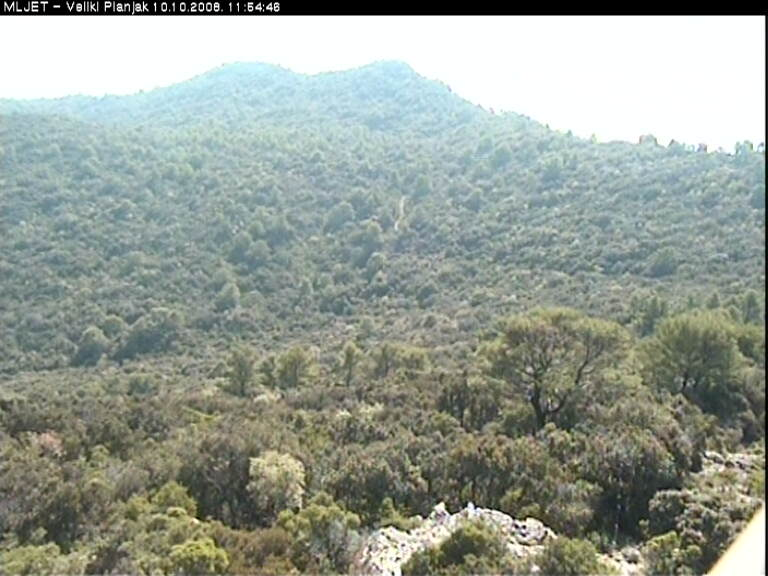

In [ ]:
display(Image(filename=input_img_paths[3]))

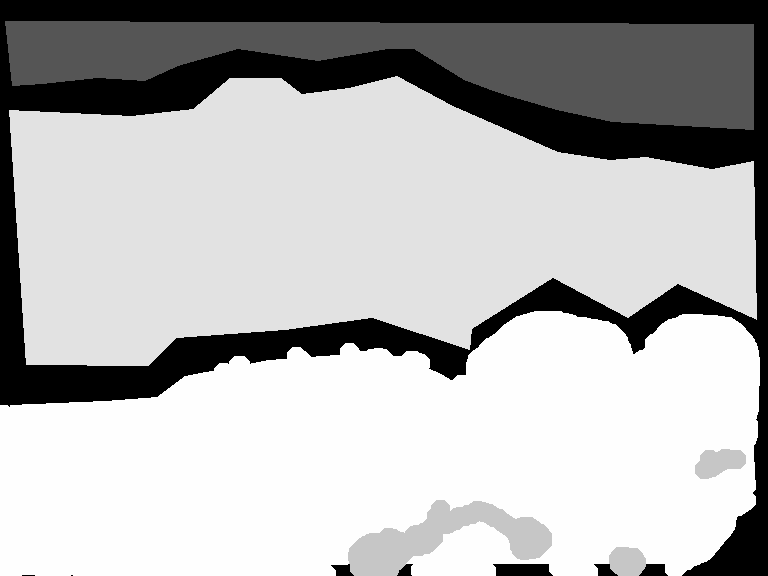

In [ ]:
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[3]))
display(img)

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
class FESB_MLID(keras.utils.Sequence):
    """ Helper to iterate over the data (as Numpy arrays). """

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """ Returns tuple (input, target) correspond to batch #idx. """

        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for image_index, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[image_index] = img

        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for target_index, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[target_index] = np.expand_dims(img, 2)
# ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[target_index] -= 1
        
        return x, y

In [ ]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### downsampling inputs

    # entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x # set aside residual

    # blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual]) # add block residual
        previous_block_activation = x # set aside residual

    ### upsampling inputs

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual]) # add block residual
        previous_block_activation = x
    
    # add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # define the model
    model = keras.Model(inputs, outputs)

    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
import random

val_samples = 20
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = FESB_MLID(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = FESB_MLID(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint("FESB_MLID_segmentation.h5", save_best_only=True)
]

epochs = 100

In [ ]:
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/100
18/18 [==============================] - 266s 14s/step - loss: 5.6853 - accuracy: 2.1605e-04 - val_loss: 23.3068 - val_accuracy: 0.0000e+00
Epoch 2/100
18/18 [==============================] - 241s 13s/step - loss: 1.8981 - accuracy: 0.0000e+00 - val_loss: 9.3128 - val_accuracy: 0.0000e+00
Epoch 3/100
18/18 [==============================] - 236s 13s/step - loss: 1.9306 - accuracy: 0.0000e+00 - val_loss: 5.2912 - val_accuracy: 0.0000e+00
Epoch 4/100
18/18 [==============================] - 234s 13s/step - loss: 1.8147 - accuracy: 0.0000e+00 - val_loss: 3.6044 - val_accuracy: 0.0000e+00
Epoch 5/100
18/18 [==============================] - 244s 14s/step - loss: 1.7080 - accuracy: 0.0000e+00 - val_loss: 3.1463 - val_accuracy: 0.0000e+00
Epoch 6/100
18/18 [==============================] - 238s 13s/step - loss: 1.6680 - accuracy: 0.0000e+00 - val_loss: 2.2024 - val_accuracy: 0.0000e+00
Epoch 7/100
18/18 [==============================] - 245s 14s/step - loss: 1.6486 - accuracy: